# Car Detection in Autonomous Driving

In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import colorsys
import imghdr
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline

C:\Users\Shweta\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Helper functions

In [2]:
#in this project we would classify data into 80 different classes mentioned in class names
def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

In [3]:
#anchors are just boxes of different dimension that we would fit our object in: we would 5 of these
def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

In [58]:
#we shall use a different color to identify objects belonging to different classes

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    np.random.seed(10101)  # Fixed seed for consistent colors across runs.
    np.random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    np.random.seed(None)  # Reset seed to default.
    return colors

In [5]:
#this is to scale the boxes according to the dimensions of the image
def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

In [6]:
#preprocess the image 
def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data

In [7]:
#drawing boxes around the objects detected
def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    
    font = ImageFont.truetype(font='font/FiraMono-Medium.otf',size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

In [49]:
# here box_confidence consists of 5 numbers specifying if there is an object detected in each anchor
# boxes represents the coordinates of boxes for the 5 anchors
# box_class_probs shows the probablilities of different classes corresponding to the 5 anchors

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    
    # Compute box scores
    box_scores = box_confidence * box_class_probs
      
    # Find the class index and score of the class with the maximum score for each anchor
    box_classes = K.argmax(box_scores, axis = -1)
    box_class_scores = K.max(box_scores, axis = -1)
    
    # Create a filtering mask (shape same as box_class_score) such that it has True for the boxes with probability >= threshold    
    filtering_mask = (box_class_scores >= threshold)
    
    # Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)

    return scores, boxes, classes

In [52]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
        
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) 
    
    # get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)

    # select only nms_indices from scores, boxes and classes
    scores = K.gather(scores, indices = nms_indices)
    boxes = K.gather(boxes, indices = nms_indices)
    classes = K.gather(classes, indices = nms_indices)
    
    return scores, boxes, classes

In [53]:
#given the outputs from the yolo model select the boxes

def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
   
    # Retrieve outputs of the YOLO model
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # perform Score-filtering with a threshold of score_threshold 
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # perform Non-max suppression with a threshold of iou_threshold
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

# Actual Program

In [8]:
# we are going to load a pretrained model and test it on car detection dataset

# create a session to start your graph
sess = K.get_session()

In [9]:
#read class names and anchors from file
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)

In [10]:
#training a YOLO model takes a very long time and requires a large dataset of bounding boxes with large range of target classes
#therefore we load a pre-trained model: This loads the weights of a YOLO model
#Essentially, this model converts a preprocessed batch of input images (shape: (m, 608, 608, 3)) into a tensor of shape (m, 19, 19, 5, 85)
yolo_model = load_model("model_data/yolo.h5")

C:\Users\Shweta\Anaconda3\lib\site-packages\keras\engine\saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [12]:
#this provides us with a model summary as to the different layers in the model
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [13]:
# The output of yolo_model is a (m, 19, 19, 5, 85) tensor that needs to pass through some processing and conversion.
# yolo_outputs gave you all the predicted boxes of yolo_model in the correct format
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [54]:
# yolo_eval performs filtering and selects only the best boxes
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

So we just developed a graph in which the <br>

yolo_model.input is given as input to yolo_model which generates yolo_model.outputs<br>
this yolo_model.outputs is processed in yolo_head and then gives yolo_outputs<br>
this yolo_output is further processed and filtered through yolo_eval and gives predictions scores, boxes, classes<br>




In [62]:
#now making a prediction for an input image

def predict(sess, image_file):
    
    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    #run the session on scores, boxes and classes to compute the graph
    res_scores, res_boxes, res_classes = sess.run([scores, boxes, classes] , feed_dict = {yolo_model.input: image_data, K.learning_phase():0})
    
    #print predictions
    print('Found {} boxes for {}'.format(len(res_boxes), image_file))
    
    #generate colors for selected class names
    colors = generate_colors(class_names)
    
    #draw boxes on the image file
    draw_boxes(image, res_scores, res_boxes, res_classes, class_names, colors)
    
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    
    # Display the results in the notebook
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return res_scores, res_boxes, res_classes

Found 7 boxes for test.jpg
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)


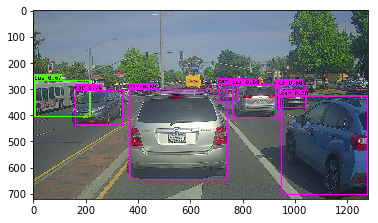

In [64]:
out_scores, out_boxes, out_classes = predict(sess, "test.jpg")

Found 4 boxes for 0004.jpg
car 0.63 (400, 285) (515, 327)
car 0.66 (95, 297) (227, 342)
car 0.68 (1, 321) (121, 410)
car 0.72 (539, 277) (658, 318)


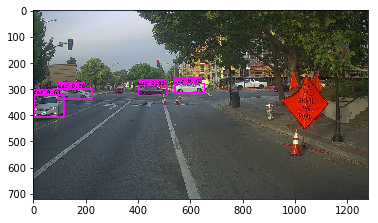

In [65]:
out_scores, out_boxes, out_classes = predict(sess, "0004.jpg")